# Исследование статистики сервиса аренды самокатов GoFast

**Задача:** Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:

**без подписки**
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

**с подпиской Ultra**
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

**Описание данных**

В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи** — users_go.csv (user_data)

- user_id - уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)


**Поездки** — rides_go.csv (rides_data)

- user_id - уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки


**Подписки** — subscriptions_go.csv (sub_data)
- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime as dt
import numpy as np
import scipy.stats as st
from math import factorial

#### Шаг 1. Загрузка данных

In [2]:
try:
    user_data = pd.read_csv('/datasets/users_go.csv')
except:
    user_data = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    
try:
    rides_data = pd.read_csv('/datasets/rides_go.csv')
except:
    rides_data = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    
try:
    sub_data = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    sub_data = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [3]:
display (user_data.head(10))
user_data.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В таблице user_data пропусков нет, типы данных соответствуют.

In [4]:
display (rides_data.head(10))
rides_data.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В таблице rides_data пропусков нет, тип данных нужно изменить в столбце date.

In [5]:
display (sub_data.head(10))
sub_data.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В таблице sub_data пропусков нет, с типами данных все в порядке.

#### Шаг 2. Предобработка данных

##### Приведите столбец date к типу даты Pandas.

In [6]:
rides_data['date'] = pd.to_datetime(rides_data['date'])

In [7]:
rides_data.info()
rides_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


##### Создайте новый столбец с номером месяца на основе столбца date.

In [8]:
rides_data['month'] = rides_data['date'].dt.month
display (rides_data.head())
print ('Начало исследуемого периода', rides_data['date'].min())
print ('Конец исследуемого периода', rides_data['date'].max())

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Начало исследуемого периода 2021-01-01 00:00:00
Конец исследуемого периода 2021-12-30 00:00:00


Данные предоставлены за 2021 год.

##### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

In [9]:
print ('Дубликатов в таблице user_data', user_data.duplicated().sum())
print ('Дубликатов в таблице rides_data', rides_data.duplicated().sum())

Дубликатов в таблице user_data 31
Дубликатов в таблице rides_data 0


В таблице user_data 31 дубликат это чуть меньше 2% от всей таблицы, удалим их. В остальных таблицах дубликатов нет.

In [10]:
user_data = user_data.drop_duplicates().reset_index(drop=True)
print ('Дубликатов в таблице user_data', user_data.duplicated().sum())

Дубликатов в таблице user_data 0


**Вывод:** Пропусков в таблицах не было, в таблице user_data был 31 дубликат (2% от всей таблицы), эти дубликаты удалили. Изменили тип данных столбца date в таблице rides_data на datetime, добавили новый столбце с номером месяца.

#### Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:

- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

##### Частота встречаемости городов

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
dtype: int64


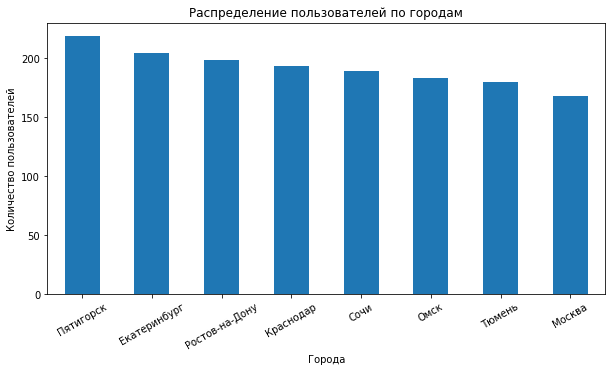

In [11]:
print (user_data.value_counts('city'))

user_data.value_counts('city').plot(kind='bar', figsize=(10,5))

plt.xticks(rotation=30)
plt.xlabel("Города")
plt.ylabel("Количество пользователей")  
plt.title("Распределение пользователей по городам")
plt.show()

Больше всего пользователей в Пятигорске - 219, как ни странно, меньше всего в Москве - 168. Количество пользователей по городам распределно достаточно равномерно.

##### Соотношение пользователей с подпиской и без подписки

subscription_type
free     835
ultra    699
dtype: int64


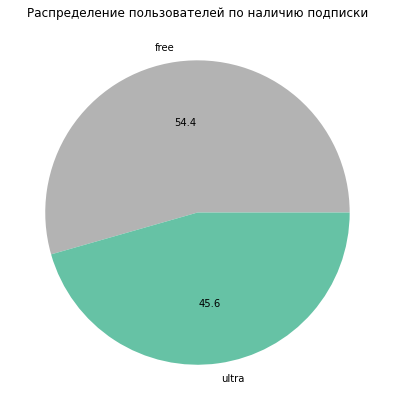

In [12]:
print (user_data.value_counts('subscription_type'))
user_data.value_counts('subscription_type').plot(
    kind='pie', subplots=True, figsize=(7, 7),
    autopct='%.1f', colormap='Set2_r')
plt.title('Распределение пользователей по наличию подписки')
plt.ylabel("")
plt.show()

Пользователей без подписки больше почти на 9%, 835 без подписки, 699 с подпиской.

##### Возраст пользователей

age
25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
dtype: int64
count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


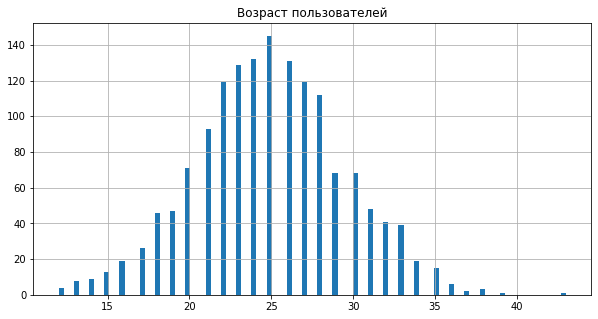

In [13]:
print (user_data.value_counts('age'))
print (user_data['age'].describe())
user_data['age'].hist(bins=100, figsize=(10,5))
plt.title('Возраст пользователей')
plt.show()

Основная часть пользователей в возрасте 22-28 лет, средний возраст 25 лет. Пользователи по возрасту распределены нормально.

##### Расстояние, которое пользователь преодолел за одну поездку

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


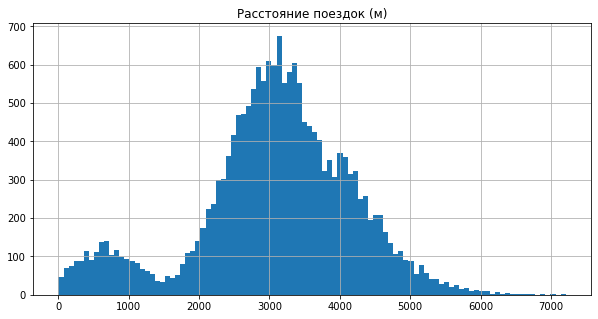

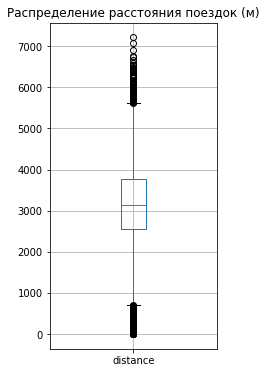

In [14]:
print(rides_data['distance'].describe())
rides_data['distance'].hist(bins=100, figsize=(10,5))
plt.title('Расстояние поездок (м)')
plt.show()
rides_data.boxplot(column='distance', figsize=(3,6))
plt.title('Распределение расстояния поездок (м)')
plt.show()

Средняя поездка составляет 3 км, в основном пользователи преодолевают за одну поезду 2.5 - 3.7 км. Минимальное значение 0,85 м выглядит странно. Возможно пользователь взял самокат и у него была неисправность или разрядился аккумулятор, либо у пользователя поменялись планы. В столбце есть достаточно большое количество выбросов, в целом распределение выглядит нормально.

##### Продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


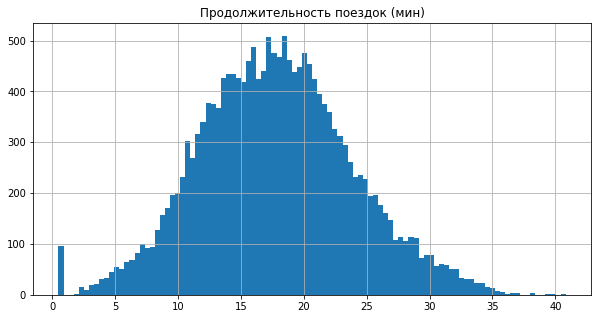

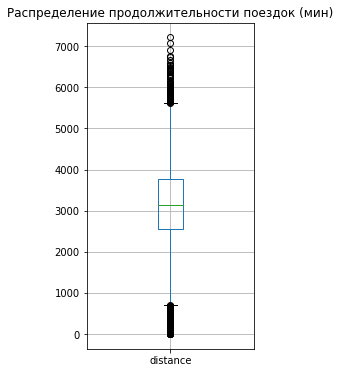

In [15]:
print(rides_data['duration'].describe())
rides_data['duration'].hist(bins=100, figsize=(10,5))
plt.title('Продолжительность поездок (мин)')
plt.show()
rides_data.boxplot(column='distance', figsize=(3,6))
plt.title('Распределение продолжительности поездок (мин)')
plt.show()

Средняя продолжительность поездки 17.8 минут, большая часть поездок находится в диапазоне 13.5 - 21.7 минут. Как и в прошлом столбце есть очень низкие значения, причины возникновения вероятно такие же. Есть выбросы в обе стороны, время поездок распределено нормально.

**Вывод:** 

В целом данные в исследуемых столбцах распределены нормально, серьезных отклонений нет. В столбцах с дистанцией и продолжительностью поездки есть выбросы в обе стороны. Очень низкие значения предположительно связаны либо с технической проблемой с самокатом, либо у пользователя могли поменяться планы.
- Больше всего пользователей в Пятигорске - 219, меньше всего в Москве - 168.
- Пользователей без подписки больше на 16%, 835 без подписки, 699 с подпиской.
- Основная часть пользователей в возрасте 22-28 лет, средний возраст 25 лет.
- Средняя поездка длится 17.8 минут, среднее расстояние поездки 3 км. Основная часть поездок находится в диапазонах 13.5 - 21.7 минут и 2.5 - 3.7 км.

#### Шаг 4. Объединение данных

4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge().

4.2 Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

##### Объедините данные о пользователях, поездках и подписках в один датафрейм.

In [16]:
main_data = rides_data.merge(user_data, on='user_id')
main_data.info()
main_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


,user_id,distance,duration,date,month,name,age,city,subscription_type
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra


##### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1

**Без подписки**

In [17]:
data_sub_free = main_data.query('subscription_type == "free"')
print('Уникальные значения столбца subscription_type:', data_sub_free['subscription_type'].unique())
data_sub_free.head()

Уникальные значения столбца subscription_type: ['free']


,user_id,distance,duration,date,month,name,age,city,subscription_type
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free


**С подпиской**

In [18]:
data_sub_ultra = main_data.query('subscription_type == "ultra"')
print('Уникальные значения столбца subscription_type:', data_sub_ultra['subscription_type'].unique())
data_sub_ultra.head()

Уникальные значения столбца subscription_type: ['ultra']


,user_id,distance,duration,date,month,name,age,city,subscription_type
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra


##### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

**Расстояние поездок**

Без подписки 
 count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64
С подпиской 
 count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


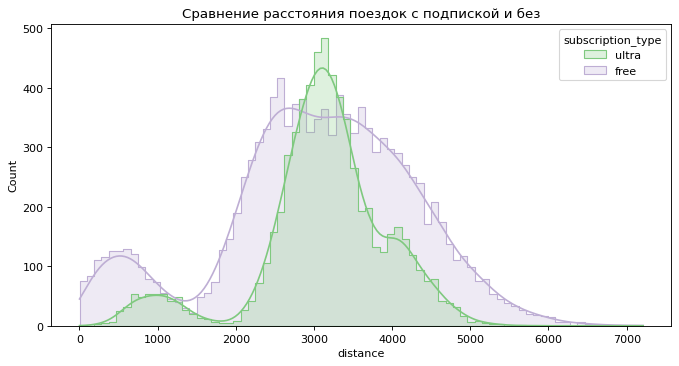

In [19]:
print('Без подписки', '\n', data_sub_free['distance'].describe())
print('С подпиской', '\n', data_sub_ultra['distance'].describe())

plt.figure(figsize=(10,5), dpi= 80)
sns.histplot(
    data=main_data,x="distance", hue="subscription_type", 
    kde=True, element="step", palette="Accent")
plt.title('Сравнение расстояния поездок с подпиской и без')
plt.show()

В обоих случаях (с подпиской и без) распределение похоже на нормальное, если не учитывать "горб" в начале. У пользователей без подписки этот горб выше и ближе к 0. В категории без подписки общая дистанция больше. Средняя дистанция поездки отличается совсем немного ultra - 3115м, free - 3045м.

**Длительность поездок**

Без подписки 
 count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64
С подпиской 
 count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


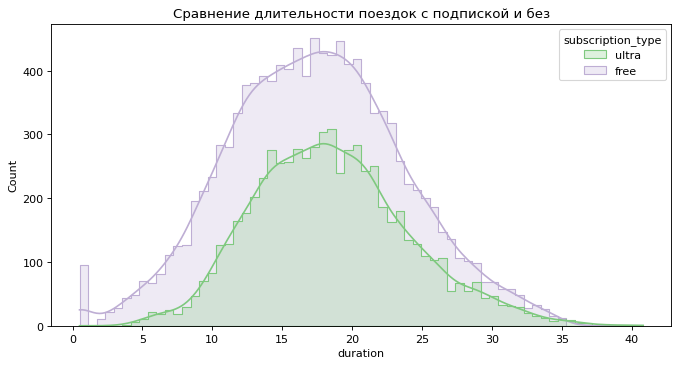

In [20]:
print('Без подписки', '\n',data_sub_free['duration'].describe())
print('С подпиской', '\n',data_sub_ultra['duration'].describe())

plt.figure(figsize=(10,5), dpi= 80)
sns.histplot(data=main_data, x="duration",
             hue="subscription_type", kde=True,
             element="step", palette="Accent")
plt.title('Сравнение длительности поездок с подпиской и без')
plt.show()

В обоих случаях распределение похоже на нормальное. Пик около нулевых значений есть только у пользователей free. В категории без подписки общая продолжительность поездок больше. Средняя продолжительность поездки отличается на целую минуту: free - 17 минут, ultra - 18 минут. Эта разница выглядит существеннее, чем разница в расстоянии.

#### Шаг 5. Подсчёт выручки

##### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [21]:
main_data['duration'] = np.ceil(main_data['duration'])

agg_data = main_data.pivot_table(
    index=['user_id', 'month', 'subscription_type'], values=['distance', 'duration'], 
    aggfunc=('sum', 'count')).reset_index()

agg_data.columns = [
    'user_id', 'month', 'subscription_type', 'trips_count',
    'distance_sum', 'duration_count', 'duration_sum']

agg_data.pop('duration_count')
agg_data.head()

,user_id,month,subscription_type,trips_count,distance_sum,duration_sum
0,1,1,ultra,2,7027.511294,42.0
1,1,4,ultra,1,754.159807,7.0
2,1,8,ultra,2,6723.470560,46.0
3,1,10,ultra,2,5809.911100,32.0
4,1,11,ultra,3,7003.499363,56.0


Создал новую таблицу на основе данных из main_data. subscription_type в индекс добавил для расчетов в следующем пункте, длительность поездок перед агрегацией округлил до следующего целого. Убрал мультииндексы и лишний столбец.

##### В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

In [22]:
agg_data = agg_data.merge(sub_data)

agg_data['revenue'] = (
    (agg_data['trips_count'] * agg_data['start_ride_price'])
    + agg_data['subscription_fee'] + 
    (agg_data['duration_sum'] * agg_data['minute_price'])
).astype(int)


agg_data.drop(agg_data.columns[[-2, -3, -4]], axis=1, inplace=True)
agg_data

,user_id,month,subscription_type,trips_count,distance_sum,duration_sum,revenue
0,1,1,ultra,2,7027.511294,42.0,451
1,1,4,ultra,1,754.159807,7.0,241
2,1,8,ultra,2,6723.470560,46.0,475
3,1,10,ultra,2,5809.911100,32.0,391
4,1,11,ultra,3,7003.499363,56.0,535
...,...,...,...,...,...,...,...
11326,1534,6,free,2,3409.468534,26.0,308
11327,1534,8,free,2,7622.453034,48.0,484
11328,1534,9,free,1,4928.173852,23.0,234
11329,1534,11,free,4,13350.015305,78.0,824


Добавил в таблицу столбцы из sub_data чтобы произвести все расчеты в одной таблице (другого способа не придумал). Посчитал выручку, изменил тип данных на int, так как выручка у нас получается целое число, но с типом float.
Удалил столбцы, которые добавлял для расчетов.

In [23]:
agg_data.groupby('subscription_type')['revenue'].mean()

subscription_type
free     328.641365
ultra    362.792191
Name: revenue, dtype: float64

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

**Нулевая гипотеза:** средние значения продолжительности поездок из двух групп равны.

**Альтернативная гипотеза:** среднее значение продолжительности поездок пользователей ultra больше, чем среднее значение пользователей без подписки

In [24]:
alpha = 0.05

results = st.ttest_ind(
    data_sub_ultra['duration'],
    data_sub_free['duration'],
    alternative='greater',
    equal_var=False)

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


Полученное значение p-value крайне мало, меньше заданного уровня значимости (даже если бы мы установили уровень значимость в 1%), поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки.

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

**Нулевая гипотеза:** средняя дистанция поездки равна 3130 метров.

**Альтернативная гипотеза:** средняя дистанция поездки превышает 3130 метров.

In [25]:
distance_value = 3130

results = st.ttest_1samp(
    data_sub_ultra['distance'],
    distance_value,
    alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 0.9195368847849785
Не отвергаем нулевую гипотезу


Не можем отвергнуть нулевую гипотезу, так как вероятность получить дистанцию поездки 3130 метров 92%. Из этого можно сделать вывод что в среднем пройденная пользователями дистанция оптимальна с точки зрения износа самоката.

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

**Нулевая гипотеза:** средние значения помесячной выручки из двух групп равны.

**Альтернативная гипотеза:** среднее значение помесячной выручки от пользователей ultra больше, чем среднее значение помесячной выручки от пользователей без подписки

In [26]:
revenue_ultra = agg_data.loc[agg_data['subscription_type'] == 'ultra', 'revenue']
revenue_free = agg_data.loc[agg_data['subscription_type'] == 'free', 'revenue']

results = st.ttest_ind(
    revenue_ultra,
    revenue_free,
    alternative='greater',
    equal_var=False)

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Полученное значение p-value крайне мало, меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской приносят больше выручки в месяц.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Здесь нужно проверить гипотезу о равенстве зависимых значений. Мы сравниваем одни и те же данные до и после изменений. Для этого нужно воспользоваться методом ttest_rel.

#### Вывод

На этапе предобработки удостоверились что пропусков в таблицах нет, в таблице user_data был 31 дубликат (2% от всей таблицы), эти дубликаты удалили. Изменили тип данных столбца date в таблице rides_data на datetime, добавили новый столбце с номером месяца.

На этапе исследовательского анализа выяснили что данные в столбцах распределены нормально, серьезных отклонений нет. В столбцах с дистанцией и продолжительностью поездки есть выбросы в обе стороны. Очень низкие значения предположительно связаны либо с технической проблемой с самокатом, либо у пользователя могли поменяться планы. Сделали следующие выводы:

- Больше всего пользователей в Пятигорске - 219, меньше всего в Москве - 168.
- Пользователей без подписки больше на 16%, 835 без подписки, 699 с подпиской.
- Основная часть пользователей в возрасте 22-28 лет, средний возраст 25 лет.
- Средняя поездка длится 17.8 минут, среднее расстояние поездки 3 км. Основная часть поездок находится в диапазонах 13.5 - 21.7 минут и 2.5 - 3.7 км.

Дальше объединили данные таблиц rides_data и user_data, после создали еще 2 таблице на основе объединеных: таблица с данными пользователей с подпиской ultra и таблица с данными пользователей без подписки. Сравнили дистанцию и длительность поездок пользователей с подпиской и без. Сделали следующие выводы:

- В обоих случаях (с подпиской и без) распределение похоже на нормальное, если не учитывать "горб" в начале. У пользователей без подписки этот горб выше и ближе к 0. В категории без подписки общая дистанция больше. Средняя дистанция поездки отличается совсем немного ultra - 3115м, free - 3045м.
- В обоих случаях распределение похоже на нормальное. Пик около нулевых значений есть только у пользователей free. В категории без подписки общая продолжительность поездок больше. Средняя продолжительность поездки отличается на целую минуту: free - 17 минут, ultra - 18 минут. Эта разница выглядит существеннее, чем разница в расстоянии.

Далее создали новую таблицу на основе данных из main_data. В ней расчитали количество поездок, сумму продолжительности и дистанции для каждого пользователя по месяцам. На основе данных из новой таблицы и таблицы sub_data расчитали ежемесячную выручку для каждого пользователя. Эти данные понадобятся для проверки гипотез.

Проверили несколько гипотез:

- **"Тратят ли пользователи с подпиской больше времени на поездки?"** - Полученное значение p-value крайне мало, меньше заданного уровня значимости (даже если бы мы установили уровень значимость в 1%), поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки.

- **"Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?"** - Не можем отвергнуть нулевую гипотезу о том что средняя дистанция поездки равна 3130 метров, так как вероятность получить дистанцию поездки 3130 метров 92%. Из этого можно сделать вывод что в среднем пройденная пользователями дистанция оптимальна с точки зрения износа самоката.

- **"Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?"** - Полученное значение p-value крайне мало, меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской приносят больше выручки в месяц.

На основе результатов исследования можно сделать вывод что пользователи с подпиской приносят больше выручки компании.